#### INSTALL AND IMPORT DEPENDENCIES

In [1]:
import tensorflow as tf
import cv2,labelme
import shutil
from pathlib import Path
import os,uuid
import matplotlib.pyplot as plt
import time,json,wget
from sklearn.model_selection import train_test_split
import numpy as np,pandas as pd
import albumentations as A
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.models import load_model
from scipy.interpolate import make_interp_spline

import os
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from PyPDF2 import PdfMerger


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

%matplotlib inline

c:\Users\bkj\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord_labelme.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
PATHS = {
    'workspace':Path('workspace'),
    'images':Path('workspace','images'),
    'train-images':Path('workspace','images','train'),
    'test-images':Path('workspace','images','test'),
    'protoc': Path('workspace','protoc'),
    'scripts': Path('workspace','scripts'),
    'pretrained-model':Path('workspace','pretrained_model'),
    'annotation':Path('workspace','annotation'),
    'models': Path('workspace','models'),
    'CHECKPOINT_PATH': Path('workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'export'),
    'TFJS_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'tfjsexport'),
    'TFLITE_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'tfliteexport'),
}


In [4]:
files = {
    'TF_RECORD_SCRIPTS': Path(PATHS['scripts'],TF_RECORD_SCRIPT_NAME),
    'LABELMAP': Path(PATHS['annotation'],LABEL_MAP_NAME),
    'PIPELINE_PATH':os.path.join(str(PATHS['pretrained-model']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','pipeline.config'),
    'CHECKPOINT_PATH': os.path.join(str(PATHS['pretrained-model']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','checkpoint')
}

In [5]:
# load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_PATH'])
detection_model = model_builder.build(model_config=configs['model'],is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATHS['CHECKPOINT_PATH'],'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image,shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image,shapes)
    detections = detection_model.postprocess(prediction_dict,shapes)
    return detections

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
IMAGEFILE_PATH = os.path.join(PATHS['test-images'],'2b11bcd1-881e-11ee-bffd-ec5c68664d70.jpg')

In [7]:

mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def get_angles(results):
        mp_pose = mp.solutions.pose
        wrist = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
        index = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX]
        elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]

        # Convert landmarks to numpy arrays
        wrist = np.array([wrist.x, wrist.y, wrist.z])
        index = np.array([index.x, index.y, index.z])
        elbow = np.array([elbow.x, elbow.y, elbow.z])

        # Calculate the vectors
        v1 = index - wrist
        v2 = elbow - wrist

        # Calculate the angle using arccos
        wrist_angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))

        wrist_angle = wrist_angle.astype(int)


        # Calculate the right elbow angle
        shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
        wrist = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
        shoulder = np.array([shoulder.x, shoulder.y])
        elbow = np.array([elbow.x, elbow.y])
        wrist = np.array([wrist.x, wrist.y])
        v1 = shoulder - elbow
        v2 = wrist - elbow
        elbow_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        elbow_angle = np.degrees(elbow_angle).astype(int)


        # Calculate the right shoulder angle
        hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
        shoulder = np.array([shoulder.x, shoulder.y,shoulder.z])
        hip = np.array([hip.x, hip.y,hip.z])
        elbow = np.array([elbow.x, elbow.y,elbow.z])

        v1 = elbow[:2] - shoulder[:2]
        v2 = hip[:2] - shoulder[:2]
        shoulder_angle = np.arccos(np.dot(v2, v1) / (np.linalg.norm(v2) * np.linalg.norm(v1)))
        shoulder_angle = np.degrees(shoulder_angle).astype(int)
        
        if elbow[0] < shoulder[0]:
            shoulder_angle = -shoulder_angle
        else:
            if abs(shoulder_angle) >= 60:
                v1 = elbow - shoulder
                v2 = hip - shoulder
                shoulder_angle = np.arccos(np.dot(v2, v1) / (np.linalg.norm(v2) * np.linalg.norm(v1)))
                shoulder_angle = np.degrees(shoulder_angle).astype(int)
            else:
                shoulder_angle = abs(shoulder_angle)

        # Calculate the hip angle
        hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        hip = np.array([hip.x, hip.y,hip.z])
        knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        knee = np.array([knee.x, knee.y, knee.z])
        shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        shoulder = np.array([shoulder.x, shoulder.y,shoulder.z])
        v1 = shoulder - hip
        v2 = knee - hip
        hip_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        hip_angle = np.degrees(hip_angle).astype(int)

        # Calculate the right knee angle
        ankle = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE]
        ankle = np.array([ankle.x, ankle.y, ankle.z])
        v1 = hip - knee
        v2 = ankle - knee
        knee_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        knee_angle = np.degrees(knee_angle).astype(int)

        # Calculate the right ankle angle
        heel = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL]
        heel = np.array([heel.x, heel.y, heel.z])
        v1 = knee - ankle
        v2 = heel - ankle
        ankle_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        ankle_angle = np.degrees(ankle_angle).astype(int) 

        return [wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle]



def display_angle_table(frame,results,width,height):
    
    wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle = get_angles(results)

    cv2.rectangle(frame, (width - 600, height - 250), (width, height), (0, 0, 0), cv2.FILLED)
    cv2.line(frame,(width - 600, height - 250), (width - 600, height ), (255,255,255), 4)
    for i in [250,210,170,130,90,50]:
        cv2.line(frame, (width - 600, height - i), (width, height - i), (255,255,255), 4)
    cv2.putText(frame, f'wrist angle: {wrist_angle}', (width - 600, height - 220), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f'elbow angle: {elbow_angle}', (width - 600, height - 180), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'shoulder angle: {shoulder_angle}', (width - 600, height - 140), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Hip angle: {hip_angle}', (width - 600, height - 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'knee angle: {knee_angle}', (width - 600, height - 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f'ankle angle: {ankle_angle}', (width - 600, height - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
    return [wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle]


def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    results = model.process(image)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return results

def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(10, 250, 80), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(250, 0, 0), thickness=2, circle_radius=2),)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 250, 80), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(250, 0, 250), thickness=2, circle_radius=2),)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(10, 250, 80), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 121, 255), thickness=2, circle_radius=2),)
    

def extract_keypoint(results):
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

def extract_images(video_path,output_folder,frames_to_extract):
    '''
    extracts images from video
    
    Arguments: 
        video_path: this is the path to the video we are extracting image from
        output_file: this is the directory our extracted image will be saved to
        frame_interval_seconds: this is the seconds interval to save each image
    '''

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_on_save = 0

    Path(output_folder).mkdir(exist_ok=True)
    folder_name = Path(video_path).stem

    while cap.isOpened():
        ret,frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Save the frame if it's within the desired interval
        if  frame_count in frames_to_extract:

            final_npy_dir = Path(output_folder,folder_name,f"{frame_on_save}.npy")
            image_np = np.array(frame)
        
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            # for i in range(len(detections['detection_boxes'])):
            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            player_frame = image_np[ymin:ymax, xmin:xmax]
            output_path = Path(output_folder, f"{str(uuid.uuid1())}.jpg")
            print(output_path)
            cv2.imwrite(str(output_path), player_frame)
    cap.release()

def view_fn(path,starting_point):
    cap = cv2.VideoCapture(path)
    frame_count = 0
    frame_to_save = 0
    folder_name = Path(path).stem
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret,frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            image_np = np.array(frame)
            
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            # for i in range(len(detections['detection_boxes'])):
            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            player_frame = image_np[ymin:ymax, xmin:xmax]
            
            margin = 50

            text_x = max(min(xmin - margin, player_frame.shape[0] - 150), 0)
            text_y = max(min(ymin - margin, player_frame.shape[1] - 150), 0)

            
            if text_x < player_frame.shape[1] and text_y < player_frame.shape[0]:
                cv2.putText(player_frame, f'{frame_count}', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                print("Text coordinates exceed frame dimensions.")
            cv2.imshow('frame',player_frame)
            

            if frame_count in np.arange(starting_point,starting_point + 25):
                image,results = mediapipe_detection(player_frame,holistic)
                extracted_results = extract_keypoint(results)
                final_npy_dir = Path('shot_detection_images','0',folder_name,f"{frame_to_save}.npy")
                Path('shot_detection_images','0',folder_name).mkdir(exist_ok=True)
                np.save(final_npy_dir,extracted_results)
                draw_landmarks(image,results)
                mp_drawing.draw_landmarks(player_frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color=(10, 250, 80), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(250, 0, 0), thickness=2, circle_radius=2),)
                frame_to_save += 1
            elif frame_count > starting_point + 25:
                break

        cap.release()
        cv2.destroyAllWindows()

def create_dataframe(keypoints,name_to_save):
    df = pd.DataFrame(keypoints,columns=['wrist_angle','elbow_angle','shoulder_angle','hip_angle','knee_angle','ankle_angle'])
    df.index = range(1, len(df) + 1)
    df.to_excel(f"{name_to_save}.xlsx")


def plot_angle_graph_and_save(frames,angles,save_as,release_frame):
    x = np.array(frames)
    y = np.array(angles)

    def normalize_to_range(arrays, target_range=(-10, 30)):
        # Find the min and max values across all arrays
        min_val = np.min(arrays)
        max_val = np.max(arrays)

        # Calculate the scaling factor
        scale_factor = (target_range[1] - target_range[0]) / (max_val - min_val)

        # Normalize each array
        normalized_arrays = [(array - min_val) * scale_factor + target_range[0] for array in arrays]

        return normalized_arrays


    labels = ["wrist_angle", "elbow_angle", "shoulder_angle", "hip_angle", "knee_angle", "ankle_angle"]
    labels_to_normalize = ["elbow_angle","hip_angle", "knee_angle", "ankle_angle"]
    normalization_threshold = { "hip_angle":(-30,0), "knee_angle":(0,-45), "ankle_angle":(-20,40)}
    df = pd.DataFrame(y,index=x,columns=labels)


    labels_to_plot = ["elbow_angle", "shoulder_angle", "wrist_angle","hip_angle", "knee_angle", "ankle_angle"]

    for col in labels_to_plot:
        y = df.loc[:,col]
        # if col == 'wrist_angle':  
        #     y = -df.loc[:,col] 

        if col in labels_to_plot[3:]:
            y = normalize_to_range(y)
        spl = make_interp_spline(x, y, k=3)
        x_smooth = np.linspace(x.min(), x.max(), 1000)
        x_smooth = np.arange(x_smooth.min(), x_smooth.max(), step=4)
        y_smooth = spl(x_smooth)
        if col == 'wrist_angle':  
            y_smooth = -y_smooth

        if col in labels_to_plot[3:]:
            plt.plot(x_smooth, y_smooth, label=col,linewidth=0.4)
        else:
            plt.plot(x_smooth, y_smooth, label=col)

    plt.axvline(x=release_frame, color='red', linestyle='--', label='Released')
    plt.title("Joint Flexion graph")
    plt.xlabel("frames")
    plt.ylabel("angles")
    plt.legend(loc="upper left", prop={'size':5})

    # Save the plot
    plt.savefig(save_as)
    plt.close()

def resize_image(img):
    target_width = 100
    height, width, _ = img.shape
    aspect_ratio = height / width
    target_height = int(target_width * aspect_ratio)
    resized_img = cv2.resize(img, (target_width, target_height))

    return resized_img


def create_pdf(pdf_filename, image_paths, folder_name,angles):
    c = canvas.Canvas(pdf_filename, pagesize=letter)

    # Add a header with the folder name
    c.setFont("Helvetica", 12)
    c.drawString(100, 750, f'Shot: #{folder_name}')


    # Draw the first image on the left side
    c.drawImage(image_paths[0], 100, 500, width=80, height=100)

    # Draw the second image on the right side
    c.drawImage(image_paths[1], 200, 500, width=300, height=200)
    c.showPage()
    c.save()

def create_combined_pdf(main_folder, pdf_filename,angles):
    merger = PdfMerger()
    print(angles)
    # Iterate through subfolders
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Check if the item in the main folder is a subfolder
        if os.path.isdir(subfolder_path):

            # List image files in the subfolder
            image_files = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Check if there are exactly 2 image files
            i = 0
            if len(image_files) == 2:
                image_paths = [os.path.join(subfolder_path, file) for file in image_files]
                
                # sheet_filename = f'{subfolder}.pdf'
                sheet_filename = os.path.join(subfolder_path,f'{subfolder}.pdf')

                # Create a PDF for each subfolder
                create_pdf(sheet_filename, image_paths, subfolder,angles[i])
                print(f'PDF created for {subfolder}')

                # Append the sheet to the main PDF
                merger.append(sheet_filename)
                i += 1
            else:
                print(f'Subfolder {subfolder} does not contain 2 images.')

    # Save the final PDF
    merger.write(pdf_filename)
    merger.close()

    # Remove individual subfolder PDFs
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path):
            pdf_path = os.path.join(main_folder,subfolder_path, f'{subfolder}.pdf')
            print(pdf_path)
            if os.path.exists(pdf_path):
                os.remove(pdf_path)

    print('PDF creation complete.')


def get_shot_pose_image(frame_num, player_angles, player_frame):
    assert len(frame_num) == len(player_angles) == len(player_frame)
    cols = ['wrist_angle', 'elbow_angle', 'shoulder_angle', 'hip_angle', 'knee_angle', 'ankle_angle']
    df = pd.DataFrame(player_angles, index=np.arange(len(frame_num)).tolist(), columns=cols)

    # Get the indices of the first 5 maximum values of shoulder_angle
    shoulder_max_indices = df['shoulder_angle'].nlargest(10).index.tolist()

    # Choose the first 3 maximum values of elbow_angle within the shoulder_max_indices
    # wrist_max_indices = df.loc[shoulder_max_indices]['wrist_angle'].nsmallest(3).index.tolist()
    elbow_max_indices = df.loc[shoulder_max_indices]['elbow_angle'].nsmallest(7).index.tolist()

    # Choose the index with the lowest value of wrist_angle within the elbow_max_indices
    final_index = df.loc[elbow_max_indices]['wrist_angle'].idxmin()
    # final_index = df.loc[wrist_max_indices]['elbow_angle'].idxmin()

    return final_index

def get_contact_prediction_and_index(images):
    results = []
    model = load_model('contact_detection.h5')

    def preprocess(img):
        handball_frame = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        handball_contact = tf.image.resize(handball_frame,(120,120))
        normalized_contact = handball_contact / 255.0
        handball_contact = np.expand_dims(normalized_contact,axis=0)
        prediction = model.predict(handball_contact)
        return prediction[0]
        
    for image in images:
        results.append(preprocess(image))
    
    index = np.argmax(results)
    return index
        

In [23]:
def do_analysis(path):
   cap = cv2.VideoCapture(path)
   fps = cap.get(cv2.CAP_PROP_FPS)
   width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
   height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
   frame_count = 0
   actions = {0:'noshot',1:'shot'}

   BUFFER_SIZE = 20 if fps < 70 else 30  # Adjust as needed
   WAITING_BUFFER_SIZE = BUFFER_SIZE + 20


   THRESHOLD = 10 if fps < 70 else 25 # Adjust as needed
   shot_frame_count_max = 12 if fps < 70 else 8
   shot_buffer = []
   waiting_buffer = []

   keypoints_per_frame = []
   player_image_frame = []
   player_image_keypoint = []
   at_shot_frame_num = []
   at_shot_frame_angles = []
   angles_for_pdf = []


   model = load_model('shot_detection_lstm.h5')
   shot_frame_count= 0
   sequences = []
   mp_pose = mp.solutions.pose
   shot_num = 0
   with mp_pose.Pose() as pose:
      while cap.isOpened(): 
            ret, frame = cap.read()

            if not ret:
               break

            frame_count += 1
            at_shot_frame_num.append(frame_count)
            image_np = np.array(frame)
            

            # Indicate frame number and fps at the top-left corner
            cv2.putText(image_np, f'Frame: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'FPS: {fps:.2f}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'Shot number: {shot_num}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'Shot frame count: {shot_frame_count}', (10, 130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                        for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            cv2.rectangle(image_np_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

            # Crop the player region and extract mediapip keypoints
            player_frame = image_np[ymin:ymax, xmin:xmax]
            player_frame_to_save = player_frame.copy()
            player_image_frame.append(player_frame_to_save)
            results = mediapipe_detection(player_frame,holistic)
            keypoints = extract_keypoint(results)
            player_image_keypoint.append(keypoints)

            draw_landmarks(player_frame,results)
            if results.pose_landmarks:
               wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle = display_angle_table(image_np_with_detections,results,width,height)
               item_list = [wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle]
               at_shot_frame_angles.append(item_list)
            else:
               item_list = [0,0,0,0,0,0]
               at_shot_frame_angles.append(item_list)

               
            sequences.append(keypoints)
            sequence = sequences[-5:]

            if len(sequence) == 5:
               y_predict = model.predict(np.expand_dims(sequence,axis=0))
               y_predict = np.argmax(y_predict)
               shot_label = actions[y_predict]
               print(shot_label)
               shot_buffer.append(shot_label)
               waiting_buffer.append(shot_label)

               if len(shot_buffer) > BUFFER_SIZE:
                  shot_buffer.pop(0)

               if len(waiting_buffer) > WAITING_BUFFER_SIZE:
                  waiting_buffer.pop(0)

               if shot_buffer.count('shot') >= THRESHOLD:
                  shot_frame_count += 1

               

               if shot_frame_count >= shot_frame_count_max:
                  if waiting_buffer[-WAITING_BUFFER_SIZE:].count('noshot') == round(0.7*WAITING_BUFFER_SIZE):
                     shot_num += 1
                     # max_shoulder_index = get_shot_pose_image(at_shot_frame_num,at_shot_frame_angles,player_image_frame)
                     max_contact_index = get_contact_prediction_and_index(player_image_frame)
                     
                     frames_to_plot = at_shot_frame_num[max_contact_index-70:max_contact_index+130]
                     angles_to_plot = at_shot_frame_angles[max_contact_index-70:max_contact_index+130]
                     angles_for_pdf.append(at_shot_frame_angles[max_contact_index])
                     


                     Path('report').mkdir(exist_ok=True)
                     at_shot_dir = Path('report') / Path(path).stem / f"{shot_num}"
                     at_shot_dir.mkdir(parents=True,exist_ok=True)
                     img_path = at_shot_dir / f"{shot_num}.jpg"
                     graph_path = at_shot_dir / f"graph_{shot_num}.png"
                     shot_frame_count = 0

                     plot_angle_graph_and_save(frames_to_plot,angles_to_plot,str(graph_path),release_frame=at_shot_frame_num[max_contact_index])
                     cv2.imwrite(str(img_path),player_image_frame[max_contact_index])
                     at_shot_frame_num = []
                     at_shot_frame_angles = []
                     player_image_frame = []
                     shot_frame_count = 0
               else:
                  if shot_buffer[-BUFFER_SIZE:].count('noshot') == BUFFER_SIZE:
                     shot_frame_count = 0

            image_np_with_detections[ymin:ymax, xmin:xmax] = player_frame
            cv2.imshow('object detection', cv2.resize(image_np_with_detections, (1200, 600)))

            
            if cv2.waitKey(1) & 0xFF == ord('q'):
               break
      cap.release()
      cv2.destroyAllWindows()
               
      pdf_init_path = os.path.join('report',f"{str(Path(path).stem)}")
      Path(pdf_init_path).mkdir(parents=True,exist_ok=True)
      create_combined_pdf(pdf_init_path, os.path.join(pdf_init_path,f"{str(Path(path).stem)}_shot_report.pdf"),angles_for_pdf)

do_analysis('videos/CharlieBrownDelaware5Shots.mov')


1/1 [==============================] - 1s 1s/step
noshot
1/1 [==============================] - 0s 61ms/step
noshot
1/1 [==============================] - 0s 43ms/step
noshot
1/1 [==============================] - 0s 46ms/step
noshot
1/1 [==============================] - 0s 66ms/step
noshot
1/1 [==============================] - 0s 64ms/step
noshot
1/1 [==============================] - 0s 48ms/step
noshot
1/1 [==============================] - 0s 48ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 42ms/step
noshot
1/1 [==============================] - 0s 32ms/step
noshot
1/1 [==============================] - 0s 35ms/step
noshot
1/1 [==============================] - 0s 61ms/step
noshot
1/1 [==============================] - 0s 55ms/step
noshot
1/1 [==============================] - 0s 44ms/step
noshot
1/1 [==============================] - 0s 61ms/step
noshot
1/1 [==============================] - 0s 33ms/step
noshot

1/1 [==============================] - 0s 58ms/step
noshot
1/1 [==============================] - 0s 46ms/step
noshot
1/1 [==============================] - 0s 51ms/step
noshot
1/1 [==============================] - 0s 32ms/step
noshot
1/1 [==============================] - 0s 34ms/step
noshot
1/1 [==============================] - 0s 33ms/step
noshot
1/1 [==============================] - 0s 40ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 59ms/step
noshot
1/1 [==============================] - 0s 39ms/step
noshot
1/1 [==============================] - 0s 49ms/step
noshot
1/1 [==============================] - 0s 63ms/step
noshot
1/1 [==============================] - 0s 35ms/step
noshot
1/1 [==============================] - 0s 43ms/step
noshot
1/1 [==============================] - 0s 38ms/step
noshot
1/1 [==============================] - 0s 41ms/step
noshot
1/1 [==============================] - 0s 33ms/step
nosh

1/1 [==============================] - 0s 87ms/step
noshot
1/1 [==============================] - 0s 50ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 34ms/step
noshot
1/1 [==============================] - 0s 31ms/step
noshot
1/1 [==============================] - 0s 39ms/step
noshot
1/1 [==============================] - 0s 34ms/step
noshot
1/1 [==============================] - 0s 37ms/step
noshot
1/1 [==============================] - 0s 37ms/step
noshot
1/1 [==============================] - 0s 30ms/step
noshot
1/1 [==============================] - 0s 44ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 34ms/step
noshot
1/1 [==============================] - 0s 37ms/step
noshot
1/1 [==============================] - 0s 32ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 39ms/step
nosh

1/1 [==============================] - 0s 76ms/step
noshot
1/1 [==============================] - 0s 34ms/step
noshot
1/1 [==============================] - 0s 41ms/step
noshot
1/1 [==============================] - 0s 33ms/step
noshot
1/1 [==============================] - 0s 40ms/step
noshot
1/1 [==============================] - 0s 39ms/step
noshot
1/1 [==============================] - 0s 40ms/step
noshot
1/1 [==============================] - 0s 38ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 37ms/step
noshot
1/1 [==============================] - 0s 33ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 40ms/step
noshot
1/1 [==============================] - 0s 41ms/step
noshot
1/1 [==============================] - 0s 43ms/step
noshot
1/1 [==============================] - 0s 36ms/step
noshot
1/1 [==============================] - 0s 41ms/step
nosh

In [74]:
dataset = pd.read_excel('trial.xlsx')
x = np.array(dataset['Unnamed: 0'].tolist())
y = np.array(dataset['elbow_angle'].tolist())
dataset

,Unnamed: 0,wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle
0,99,115,85,-1,100,112,133
1,100,114,86,-3,99,111,133
2,101,123,81,0,98,116,134
3,102,122,78,0,101,122,131
4,103,126,83,-1,102,125,133
...,...,...,...,...,...,...,...
141,240,82,168,-16,140,131,134
142,241,89,162,14,138,131,129
143,242,93,164,-19,139,134,130
144,243,115,161,-37,140,135,133


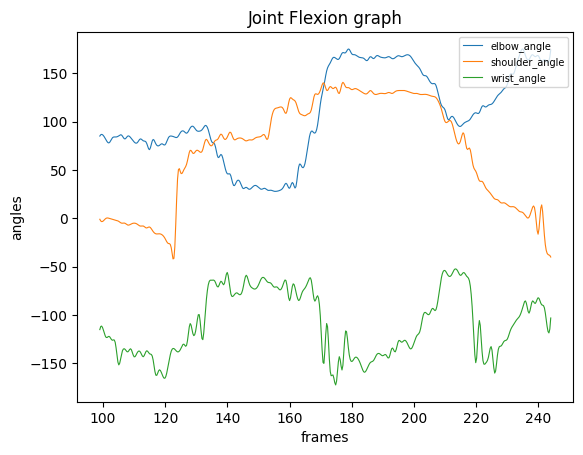

In [73]:
labels_to_plot = ["elbow_angle", "shoulder_angle", "wrist_angle"]

for col in labels_to_plot:
    y_new = dataset.loc[:,col] 
    if col == 'wrist_angle':  
        y_new = -dataset.loc[:,col] 
    X_Y_Spline1 = make_interp_spline(x,y_new,k=3)
    X_ = np.linspace(x.min(), x.max(), 500)
    x_smooth = np.arange(X_.min(),X_.max(),step=4)
    Y_ = X_Y_Spline1(X_)
    plt.plot(X_,Y_,label=col,linewidth=0.8)

# plt.axvline(x=release_frame, color='red', linestyle='--', label='Released')
plt.title("Joint Flexion graph")
plt.xlabel("frames")
plt.ylabel("angles")
plt.legend(loc="upper right", prop={'size':7})

# Save the plot
# plt.savefig(save_as)
plt.show()

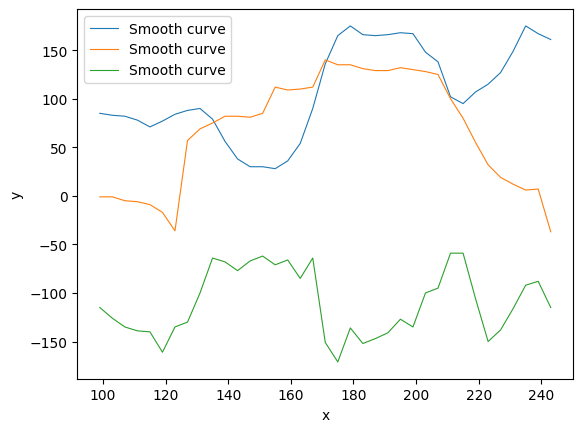

In [83]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

labels_to_plot = ["elbow_angle", "shoulder_angle", "wrist_angle"]

for col in labels_to_plot:
    y = dataset.loc[:,col]
    if col == 'wrist_angle':  
        y_new = -dataset.loc[:,col] 
    # Create a spline interpolation of degree 3 (cubic)
    spl = make_interp_spline(x, y, k=3)
    x_smooth = np.linspace(x.min(), x.max(), 1000)
    x_smooth = np.arange(x_smooth.min(), x_smooth.max(), step=4)
    y_smooth = spl(x_smooth)
    if col == 'wrist_angle':  
        y_smooth = -y_smooth
    plt.plot(x_smooth, y_smooth, label='Smooth curve',linewidth=0.8)

# Plot the original data and the smooth curve
# plt.plot(x, y, label='Original data')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [82]:
-y_smooth

array([-115., -126., -135., -139., -140., -161., -135., -130., -100.,
        -64.,  -68.,  -77.,  -67.,  -62.,  -71.,  -66.,  -85.,  -64.,
       -151., -171., -136., -152., -147., -141., -127., -135., -100.,
        -95.,  -59.,  -59., -106., -150., -138., -116.,  -92.,  -88.,
       -115.])

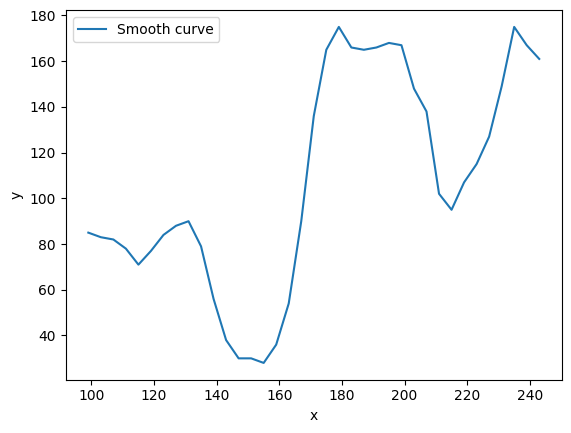

In [75]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


# Create a spline interpolation of degree 3 (cubic)
spl = make_interp_spline(x, y, k=3)
x_smooth = np.linspace(x.min(), x.max(), 500)
x_smooth = np.arange(x_smooth.min(), x_smooth.max(), step=4)
y_smooth = spl(x_smooth)

# Plot the original data and the smooth curve
# plt.plot(x, y, label='Original data')
plt.plot(x_smooth, y_smooth, label='Smooth curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


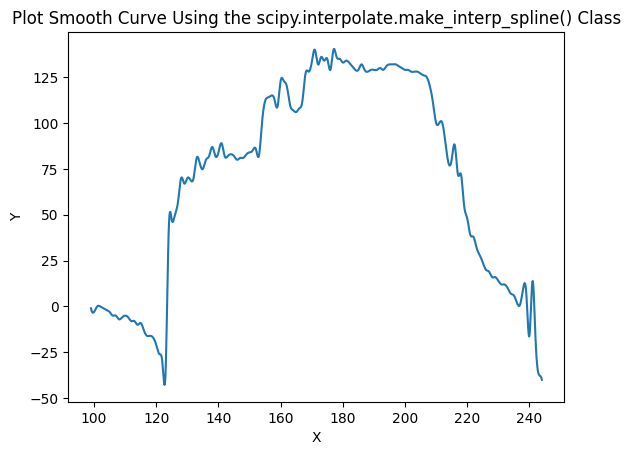

In [53]:
import numpy as np
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt 

# Dataset
x = np.array(x)
y = np.array(y)

X_Y_Spline = make_interp_spline(x, y, k=3)

# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 1000)
Y_ = X_Y_Spline(X_)

# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Given data
y = np.array([ -1,  -3,   0,   0,  -1,  -2,  -3,  -5,  -5,  -7,  -6,  -5,  -6,
        -8,  -8, -10,  -9, -13, -16, -16, -17, -21, -26, -31, -36,  41,
        47,  50,  57,  70,  67,  70,  69,  70,  81,  78,  75,  80,  82,
        87,  82,  84,  89,  82,  82,  83,  82,  80,  81,  81,  83,  84,
        85,  86,  82, 100, 112, 114, 115, 113, 109, 123, 123, 120, 110,
       107, 106, 108, 112, 127, 128, 133, 140, 132, 136, 134, 135, 129,
       140, 136, 135, 133, 134, 133, 131, 129, 129, 132, 129, 128, 129,
       129, 129, 130, 129, 131, 132, 132, 132, 131, 130, 129, 129, 128,
       128, 128, 127, 126, 125, 120, 111, 100, 100, 100,  89,  78,  80,
        88,  72,  72,  55,  48,  39,  38,  32,  28,  24,  20,  19,  16,
        16,  14,  12,  12,  10,   7,   6,   2,   1,  10,   7, -16,  14,
       -19, -37, -40])

x = np.array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244])

# Replace NaN values with a specific value before padding
nan_replacement = 0  # Choose a value to replace NaN
y = np.nan_to_num(y, nan=nan_replacement)
x = np.nan_to_num(x, nan=nan_replacement)

# Pad the arrays to make their lengths divisible by 10
y = np.pad(y, (0, 10 - len(y) % 10), mode='constant', constant_values=nan_replacement)
x = np.pad(x, (0, 10 - len(x) % 10), mode='constant', constant_values=nan_replacement)

# Take the average of every 10 points
y_avg = np.nanmean(y.reshape(-1, 10), axis=1)
x_avg = np.nanmean(x.reshape(-1, 10), axis=1)

# Use cubic spline interpolation for a smooth plot
X_Y_Spline1 = make_interp_spline(x_avg, y_avg, k=3)
X_ = np.linspace(x.min(), x.max(), 1000)
Y_ = X_Y_Spline1(X_)

# Plot the smoothed curve
plt.plot(X_, Y_, label='Smoothed Curve', linewidth=2)
plt.scatter(x, y, label='Original Data', color='red', marker='o')
plt.title('Smoothed Trajectory of the Curve (Averaging Every 10 Points)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


ValueError: Expect x to be a 1D strictly increasing sequence.

In [ ]:
# do_analysis('videos/KylorKelley5Shots.mov')
do_analysis('videos/CharlieBrownDelaware5Shots.mov')
# do_analysis('videos/CoreyHawkins5Shots.mov')
do_analysis('videos/DavonteFitzgerald5Shots.mov')
do_analysis('videos/Elfrid5Shots.mov')
do_analysis('videos/GregBrown5Shots.mov')
do_analysis('videos/JaredBrownrigdge5shots.mov')
do_analysis('videos/JordanWalker5Shots.MOV')
do_analysis('videos/KalleFinland5Shots.mov')
do_analysis('videos/Maxi5Shot.mov')
do_analysis('videos/OMax5Shot.mov')
do_analysis('videos/SergeIbaka x5.mov')
do_analysis('videos/SteveSir5Shots.mov')

##### BALL HAND CONTACT DETECTION 

In [ ]:
def contact_analysis(path):
   cap = cv2.VideoCapture(path)
   width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
   height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
   frame_count = 0
   model = load_model('contact_detection.h5')
   mp_pose = mp.solutions.pose
   with mp_pose.Pose() as pose:
      while cap.isOpened(): 
            ret, frame = cap.read()

            if not ret:
               break

            frame_count += 1
            image_np = np.array(frame)
            

            # Indicate frame number and fps at the top-left corner
            # cv2.putText(image_np, f'Frame: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            # cv2.putText(image_np, f'FPS: {fps:.2f}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            # cv2.putText(image_np, f'Shot number: {shot_num}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            # cv2.putText(image_np, f'Shot frame count: {shot_frame_count}', (10, 130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                        for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            cv2.rectangle(image_np_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

            # Crop the player region and extract mediapip keypoints
            player_frame = image_np[ymin:ymax, xmin:xmax]

            handball_frame = player_frame.copy()
            handball_frame = cv2.cvtColor(handball_frame,cv2.COLOR_BGR2RGB)
            handball_contact = tf.image.resize(handball_frame,(120,120))
            x = f'inspect/{str(uuid.uuid1())}.jpg'
            normalized_contact = handball_contact / 255.0
            handball_contact = np.expand_dims(normalized_contact,axis=0)
            prediction = model.predict(handball_contact)
            print(prediction)


            image_np_with_detections[ymin:ymax, xmin:xmax] = player_frame
            cv2.imshow('object detection', cv2.resize(image_np_with_detections, (1200, 600)))

            
            if cv2.waitKey(1) & 0xFF == ord('q'):
               break
      cap.release()
      cv2.destroyAllWindows()
               

contact_analysis('videos/CoreyHawkins5Shots.mov')

1/1 [==============================] - 0s 408ms/step
[array([[0.97842616]], dtype=float32), array([[0.11653714, 0.08986113, 0.57408196, 0.30401647]], dtype=float32)]
1/1 [==============================] - 0s 146ms/step
[array([[0.52022463]], dtype=float32), array([[0.1269732 , 0.08152649, 0.37305382, 0.2082402 ]], dtype=float32)]
1/1 [==============================] - 0s 148ms/step
[array([[0.54550105]], dtype=float32), array([[0.13776661, 0.08895184, 0.39683995, 0.21594733]], dtype=float32)]
1/1 [==============================] - 0s 110ms/step
[array([[0.68695885]], dtype=float32), array([[0.14052165, 0.09188948, 0.4378633 , 0.24615188]], dtype=float32)]
1/1 [==============================] - 0s 111ms/step
[array([[0.5867566]], dtype=float32), array([[0.15495877, 0.10218192, 0.43296373, 0.22995076]], dtype=float32)]
1/1 [==============================] - 0s 113ms/step
[array([[0.51234984]], dtype=float32), array([[0.15017092, 0.09299162, 0.3933451 , 0.21213184]], dtype=float32)]
1/1 [

In [ ]:
model = load_model('ball-hand-detection.h5')
img = cv2.imread('inspect/4e4445cb-9d1a-11ee-af9f-ec5c68664d6f.jpg')
new_img = np.expand_dims(img /255.0 ,axis=0)

In [ ]:
y_pred = model.predict(new_img)
y_pred

1/1 [==============================] - 1s 528ms/step


[array([[0.97014564]], dtype=float32),
 array([[0.31621358, 0.08684632, 0.4754446 , 0.17188716]], dtype=float32)]

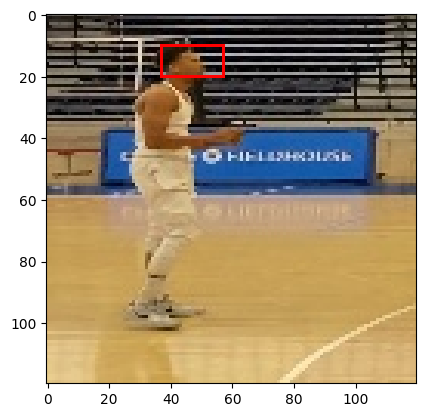

In [ ]:
cv2.rectangle(img,
              tuple(np.multiply(y_pred[1][0][:2],[120,120]).astype(int)),
              tuple(np.multiply(y_pred[1][0][2:],[120,120]).astype(int)),
              (255,0,0))
plt.imshow(img)

In [ ]:
y_pred[1][0]

array([0.31621358, 0.08684632, 0.4754446 , 0.17188716], dtype=float32)

In [ ]:
# # do_analysis('videos/KylorKelley5Shots.mov')
# do_analysis('videos/CharlieBrownDelaware5Shots.mov')
# do_analysis('videos/CoreyHawkins5Shots.mov')
# do_analysis('videos/DavonteFitzgerald5Shots.mov')
# do_analysis('videos/Elfrid5Shots.mov')
# do_analysis('videos/GregBrown5Shots.mov')
# do_analysis('videos/JaredBrownrigdge5shots.mov')
# do_analysis('videos/JordanWalker5Shots.MOV')
# do_analysis('videos/KalleFinland5Shots.mov')
# do_analysis('videos/Maxi5Shot.mov')
# do_analysis('videos/OMax5Shot.mov')
# do_analysis('videos/SergeIbaka x5.mov')
# do_analysis('videos/SteveSir5Shots.mov')

In [ ]:
# get_frame_details('videos/CharlieBrownDelaware5Shots.mov',[170,620,1114,1627,2142])
# get_frame_details('videos/CoreyHawkins5Shots.mov',[92,400,714,997,1268])
# get_frame_details('videos/DavonteFitzgerald5Shots.mov',[248,564,906,1192,1495])
# get_frame_details('videos/Elfrid5Shots.mov',[125,446,781,1208,1640])
# get_frame_details('videos/Facu5shots.mov',[120,391,665,998,1315])
# get_frame_details('videos/GregBrown5Shots.mov',[195,627,1076,1592,2124])
# get_frame_details('videos/JaredBrownrigdge5shots.mov',[188,803,1281,1752,2263])
# get_frame_details('videos/JordanWalker5Shots.MOV',[150,579,1045,1462,1890])
# get_frame_details('videos/KylorKelley5Shots.mov',[220,702,1179,1826,2327])
# get_frame_details('videos/Maxi5Shot.mov',[165,571,1115,1608,2070])
# get_frame_details('videos/OMax5Shot.mov',[55,634,1100,1558,2108])
# get_frame_details('videos/SergeIbaka x5.mov',[166,449,718,1014,1381])
# get_frame_details('videos/SteveSir5Shots.mov',[170,605,1144,1663,2102])

In [ ]:
# get_frame_details('videos/CharlieBrownDelaware5Shots.mov',[1,90,240,290,350],shot_status='noshot')
# get_frame_details('videos/CoreyHawkins5Shots.mov',[1,58,142,160,180],shot_status='noshot')
# get_frame_details('videos/DavonteFitzgerald5Shots.mov',[1,45,95,210,290],shot_status='noshot')
# get_frame_details('videos/Elfrid5Shots.mov',[1,85,165,180,205],shot_status='noshot')
# get_frame_details('videos/Facu5shots.mov',[1,80,170,235,270],shot_status='noshot')
# get_frame_details('videos/GregBrown5Shots.mov',[1,70,155,300,337],shot_status='noshot')
# get_frame_details('videos/JaredBrownrigdge5shots.mov',[1,100,135,265,320],shot_status='noshot')
# get_frame_details('videos/JordanWalker5Shots.MOV',[1,70,110,230,280],shot_status='noshot')
# get_frame_details('videos/KylorKelley5Shots.mov',[1,160,280,310,340],shot_status='noshot')
# get_frame_details('videos/Maxi5Shot.mov',[1,75,115,260,320],shot_status='noshot')
# get_frame_details('videos/OMax5Shot.mov',[1,15,200,260,325],shot_status='noshot')
# get_frame_details('videos/SergeIbaka x5.mov',[1,15,130,270,300],shot_status='noshot')
# get_frame_details('videos/SteveSir5Shots.mov',[1,160,280,310,340],shot_status='noshot')